# RNN: Hyperparameter Optimization

In [1]:
import os
import numpy as np
import pandas as pd

# for printing the definition of custom functions
import inspect

# models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from pmdarima.arima import auto_arima

# pytorch
from torch import nn, no_grad, save, load
from torch import from_numpy, zeros
from torch.optim import SGD
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

# plots
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
%matplotlib inline

import pickle

C:\Users\hauer\anaconda3\envs\test\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [28]:
models = []
n_epochs = 350

In [3]:
database_dir = os.path.join(r'C:/Users/hauer/Documents/Repositories/cfds_project', 'database.pickle')

with open(database_dir,'rb') as f: 
    db = pickle.load(f)
    
database_training = db['database_training']
database_validation = db['database_validation']
database_test = db['database_test']

database_training_sv = db['database_training_sv']
database_validation_sv = db['database_validation_sv']
database_test_sv = db['database_test_sv']

database_training_sv_standard = db['database_training_sv_standard']
database_validation_sv_standard = db['database_validation_sv_standard']
database_test_sv_standard = db['database_test_sv_standard']

database_scaler = db['database_scaler']

In [4]:
# =============================================================================
# RNN start
# =============================================================================


# =============================================================================
# # Prepare Data for RNN
# =============================================================================



N, dummy_dim = database_training_sv_standard['Germany'].shape
dummy_dim -= 1

time_steps = 16
horizon = 1
sequence_length = time_steps + horizon 


max_index = N - sequence_length + 1

number_of_countries = len(database_training_sv_standard.keys())

X = np.empty([0, sequence_length,dummy_dim])
y = np.empty([0, sequence_length])

 

for country in database_training.keys():
    df_training_current = database_training_sv_standard[country]

    X_current = np.empty([max_index, sequence_length,dummy_dim])
    y_current = np.empty([max_index, sequence_length])

    for i in range(max_index):

        X_current[i] = df_training_current.iloc[i:i+sequence_length,1:].values
        y_current[i] = df_training_current.iloc[i:i+sequence_length,0].values
        
    X = np.concatenate((X, X_current))
    y = np.concatenate((y, y_current))
    
    
    

N, seq_len, dummy_dim = X.shape

input_size=dummy_dim
n_layers=1
output_size=1
test_size = 0.20
batch_size = 25




X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=123)


X_train_T = from_numpy(X_train).float()
y_train_T = from_numpy(y_train).float()
X_val_T = from_numpy(X_val).float()
y_val_T = from_numpy(y_val).float()

train_ds = TensorDataset(X_train_T, y_train_T)
train_dl = DataLoader(train_ds, batch_size=batch_size)  

valid_ds = TensorDataset(X_val_T, y_val_T)
valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2)

loss_func = nn.MSELoss()

# Simple RNN

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        r_out, hidden = self.rnn(x, hidden)
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)
    
name = 'RNN'
hidden_dim=3
lr = 0.03

model = RNN(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = SGD(model.parameters(), lr = lr)  

hidden_0 = zeros(1, seq_len, hidden_dim)
training_losses = np.empty(n_epochs)
valid_losses = np.empty(n_epochs)

# =============================================================================
# # Training loop 
# =============================================================================

for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        
        y_pred = model(X_batch, hidden_0)
        
        loss = loss_func(y_pred.squeeze(), y_batch)
        
        training_loss += loss.item()
       

        loss.backward()
        optimizer.step()
   

    model.eval()
    valid_loss = 0
    with no_grad():
        for X_batch, y_batch in valid_dl:
            y_pred = model(X_batch, hidden_0)
            loss = loss_func(y_pred.squeeze(), y_batch.squeeze()) 
            valid_loss += loss.item()
    
    
    training_loss_epoch = training_loss 
    valid_loss_epoch = valid_loss 
    
    training_losses[epoch] = training_loss_epoch
    valid_losses[epoch] = valid_loss_epoch
    
    if epoch % 100 == 0:
        print('Epoch {}: train loss: {:.4} valid loss: {:.4}'
              .format(epoch, training_loss_epoch, valid_loss_epoch))   
        
models.append( (name, training_losses, valid_losses))

Epoch 0: train loss: 19.94 valid loss: 3.222
Epoch 100: train loss: 17.97 valid loss: 3.028
Epoch 200: train loss: 17.71 valid loss: 3.01
Epoch 300: train loss: 17.64 valid loss: 3.005
Epoch 400: train loss: 17.6 valid loss: 2.995
Epoch 500: train loss: 17.59 valid loss: 2.986
Epoch 600: train loss: 17.57 valid loss: 2.98
Epoch 700: train loss: 17.57 valid loss: 2.975
Epoch 800: train loss: 17.56 valid loss: 2.971
Epoch 900: train loss: 17.55 valid loss: 2.966
Epoch 1000: train loss: 17.53 valid loss: 2.959
Epoch 1100: train loss: 17.5 valid loss: 2.946
Epoch 1200: train loss: 17.45 valid loss: 2.932
Epoch 1300: train loss: 17.4 valid loss: 2.923
Epoch 1400: train loss: 17.35 valid loss: 2.915
Epoch 1500: train loss: 17.31 valid loss: 2.909
Epoch 1600: train loss: 17.27 valid loss: 2.903
Epoch 1700: train loss: 17.22 valid loss: 2.897
Epoch 1800: train loss: 17.19 valid loss: 2.892
Epoch 1900: train loss: 17.15 valid loss: 2.887
Epoch 2000: train loss: 17.12 valid loss: 2.883
Epoch 210

# Simple RNN Adam

In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        r_out, hidden = self.rnn(x, hidden)
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)
    
name = 'RNN_Adam'
hidden_dim=3
lr = 1e-06

model = RNN(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = Adam(model.parameters(), lr=lr)
 

hidden_0 = zeros(1, seq_len, hidden_dim)
training_losses = np.empty(n_epochs)
valid_losses = np.empty(n_epochs)

# =============================================================================
# # Training loop 
# =============================================================================

for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        
        y_pred = model(X_batch, hidden_0)
        
        loss = loss_func(y_pred.squeeze(), y_batch)
        
        training_loss += loss.item()
       

        loss.backward()
        optimizer.step()
   

    model.eval()
    valid_loss = 0
    with no_grad():
        for X_batch, y_batch in valid_dl:
            y_pred = model(X_batch, hidden_0)
            loss = loss_func(y_pred.squeeze(), y_batch.squeeze()) 
            valid_loss += loss.item()
    
    
    training_loss_epoch = training_loss 
    valid_loss_epoch = valid_loss 
    
    training_losses[epoch] = training_loss_epoch
    valid_losses[epoch] = valid_loss_epoch
    
    if epoch % 100 == 0:
        print('Epoch {}: train loss: {:.4} valid loss: {:.4}'
              .format(epoch, training_loss_epoch, valid_loss_epoch))   
        
models.append( (name, training_losses, valid_losses))


Epoch 0: train loss: 24.13 valid loss: 4.054
Epoch 100: train loss: 24.0 valid loss: 4.032
Epoch 200: train loss: 23.88 valid loss: 4.011
Epoch 300: train loss: 23.76 valid loss: 3.991
Epoch 400: train loss: 23.64 valid loss: 3.971
Epoch 500: train loss: 23.53 valid loss: 3.951
Epoch 600: train loss: 23.41 valid loss: 3.931
Epoch 700: train loss: 23.3 valid loss: 3.911
Epoch 800: train loss: 23.19 valid loss: 3.892
Epoch 900: train loss: 23.08 valid loss: 3.874
Epoch 1000: train loss: 22.97 valid loss: 3.855
Epoch 1100: train loss: 22.87 valid loss: 3.837
Epoch 1200: train loss: 22.76 valid loss: 3.819
Epoch 1300: train loss: 22.66 valid loss: 3.801
Epoch 1400: train loss: 22.56 valid loss: 3.784
Epoch 1500: train loss: 22.46 valid loss: 3.766
Epoch 1600: train loss: 22.36 valid loss: 3.749
Epoch 1700: train loss: 22.27 valid loss: 3.733
Epoch 1800: train loss: 22.17 valid loss: 3.716
Epoch 1900: train loss: 22.08 valid loss: 3.7
Epoch 2000: train loss: 21.99 valid loss: 3.684
Epoch 21

# RNN Large

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        r_out, hidden = self.rnn(x, hidden)
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)
    
name = 'RNN_Large_Adam'
hidden_dim=64
lr = 1e-06

model = RNN(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = Adam(model.parameters(), lr=lr)
 

hidden_0 = zeros(1, seq_len, hidden_dim)
training_losses = np.empty(n_epochs)
valid_losses = np.empty(n_epochs)

# =============================================================================
# # Training loop 
# =============================================================================

for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        
        y_pred = model(X_batch, hidden_0)
        
        loss = loss_func(y_pred.squeeze(), y_batch)
        
        training_loss += loss.item()
       

        loss.backward()
        optimizer.step()
   

    model.eval()
    valid_loss = 0
    with no_grad():
        for X_batch, y_batch in valid_dl:
            y_pred = model(X_batch, hidden_0)
            loss = loss_func(y_pred.squeeze(), y_batch.squeeze()) 
            valid_loss += loss.item()
    
    
    training_loss_epoch = training_loss 
    valid_loss_epoch = valid_loss 
    
    training_losses[epoch] = training_loss_epoch
    valid_losses[epoch] = valid_loss_epoch
    
    if epoch % 100 == 0:
        print('Epoch {}: train loss: {:.4} valid loss: {:.4}'
              .format(epoch, training_loss_epoch, valid_loss_epoch))   
        
models.append( (name, training_losses, valid_losses))


Epoch 0: train loss: 18.57 valid loss: 3.122
Epoch 100: train loss: 18.5 valid loss: 3.108
Epoch 200: train loss: 18.45 valid loss: 3.099
Epoch 300: train loss: 18.42 valid loss: 3.091
Epoch 400: train loss: 18.39 valid loss: 3.085
Epoch 500: train loss: 18.36 valid loss: 3.08
Epoch 600: train loss: 18.34 valid loss: 3.076
Epoch 700: train loss: 18.32 valid loss: 3.072
Epoch 800: train loss: 18.31 valid loss: 3.069
Epoch 900: train loss: 18.29 valid loss: 3.066
Epoch 1000: train loss: 18.28 valid loss: 3.064
Epoch 1100: train loss: 18.27 valid loss: 3.062
Epoch 1200: train loss: 18.26 valid loss: 3.06
Epoch 1300: train loss: 18.25 valid loss: 3.059
Epoch 1400: train loss: 18.25 valid loss: 3.057
Epoch 1500: train loss: 18.24 valid loss: 3.056
Epoch 1600: train loss: 18.24 valid loss: 3.055
Epoch 1700: train loss: 18.24 valid loss: 3.054
Epoch 1800: train loss: 18.23 valid loss: 3.054
Epoch 1900: train loss: 18.23 valid loss: 3.053
Epoch 2000: train loss: 18.23 valid loss: 3.053
Epoch 2

# Simple LSTM

In [8]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(LSTMNet, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
               
        
        self.lstm1 = nn.LSTM(input_size, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden, state):
        r_out, (hidden_out, state_out) = self.lstm1(x, (hidden, state))
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)




name = 'LSTM'
hidden_dim=10
lr = 0.03

model = LSTMNet(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = SGD(model.parameters(), lr = lr)  

hidden_0 = zeros(1, seq_len, hidden_dim)
state_0 = zeros(1, seq_len, hidden_dim)
training_losses = np.empty(n_epochs)
valid_losses = np.empty(n_epochs)


    
# =============================================================================
# # Training loop 
# =============================================================================



for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        
        y_pred = model(X_batch, hidden_0, state_0)
        
        loss = loss_func(y_pred.squeeze(), y_batch)
        
        training_loss += loss.item()
       

        loss.backward()
        optimizer.step()
   

    model.eval()
    valid_loss = 0
    with no_grad():
        for X_batch, y_batch in valid_dl:
            y_pred = model(X_batch, hidden_0, state_0)
            loss = loss_func(y_pred.squeeze(), y_batch.squeeze()) 
            valid_loss += loss.item()
    
    
    training_loss_epoch = training_loss 
    valid_loss_epoch = valid_loss 
    
    training_losses[epoch] = training_loss_epoch
    valid_losses[epoch] = valid_loss_epoch
    
    if epoch % 100 == 0:
        print('Epoch {}: train loss: {:.4} valid loss: {:.4}'
              .format(epoch, training_loss_epoch, valid_loss_epoch))  
        
        
models.append( (name, training_losses, valid_losses))
    

Epoch 0: train loss: 18.69 valid loss: 3.078
Epoch 100: train loss: 18.14 valid loss: 3.053
Epoch 200: train loss: 17.62 valid loss: 3.001
Epoch 300: train loss: 17.0 valid loss: 2.96
Epoch 400: train loss: 16.54 valid loss: 2.933
Epoch 500: train loss: 16.12 valid loss: 2.879
Epoch 600: train loss: 15.73 valid loss: 2.814
Epoch 700: train loss: 15.39 valid loss: 2.768
Epoch 800: train loss: 15.08 valid loss: 2.741
Epoch 900: train loss: 14.78 valid loss: 2.718
Epoch 1000: train loss: 14.52 valid loss: 2.699
Epoch 1100: train loss: 14.28 valid loss: 2.683
Epoch 1200: train loss: 14.07 valid loss: 2.67
Epoch 1300: train loss: 13.85 valid loss: 2.657
Epoch 1400: train loss: 13.64 valid loss: 2.638
Epoch 1500: train loss: 13.45 valid loss: 2.618
Epoch 1600: train loss: 13.26 valid loss: 2.602
Epoch 1700: train loss: 13.1 valid loss: 2.592
Epoch 1800: train loss: 12.95 valid loss: 2.588
Epoch 1900: train loss: 12.81 valid loss: 2.587
Epoch 2000: train loss: 12.68 valid loss: 2.587
Epoch 21

# LSTM Adam Large

In [9]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(LSTMNet, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
               
        
        self.lstm1 = nn.LSTM(input_size, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden, state):
        r_out, (hidden_out, state_out) = self.lstm1(x, (hidden, state))
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)




name = 'LSTM_Large_Adam'
hidden_dim=64
lr = 1e-06

model = LSTMNet(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = Adam(model.parameters(), lr=lr)


hidden_0 = zeros(1, seq_len, hidden_dim)
state_0 = zeros(1, seq_len, hidden_dim)
training_losses = np.empty(n_epochs)
valid_losses = np.empty(n_epochs)


    
# =============================================================================
# # Training loop 
# =============================================================================



for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        
        y_pred = model(X_batch, hidden_0, state_0)
        
        loss = loss_func(y_pred.squeeze(), y_batch)
        
        training_loss += loss.item()
       

        loss.backward()
        optimizer.step()
   

    model.eval()
    valid_loss = 0
    with no_grad():
        for X_batch, y_batch in valid_dl:
            y_pred = model(X_batch, hidden_0, state_0)
            loss = loss_func(y_pred.squeeze(), y_batch.squeeze()) 
            valid_loss += loss.item()
    
    
    training_loss_epoch = training_loss 
    valid_loss_epoch = valid_loss 
    
    training_losses[epoch] = training_loss_epoch
    valid_losses[epoch] = valid_loss_epoch
    
    if epoch % 100 == 0:
        print('Epoch {}: train loss: {:.4} valid loss: {:.4}'
              .format(epoch, training_loss_epoch, valid_loss_epoch))  
        
        
models.append( (name, training_losses, valid_losses))
    

Epoch 0: train loss: 18.53 valid loss: 3.098
Epoch 100: train loss: 18.51 valid loss: 3.095
Epoch 200: train loss: 18.5 valid loss: 3.093
Epoch 300: train loss: 18.48 valid loss: 3.091
Epoch 400: train loss: 18.47 valid loss: 3.089
Epoch 500: train loss: 18.45 valid loss: 3.087
Epoch 600: train loss: 18.44 valid loss: 3.086
Epoch 700: train loss: 18.43 valid loss: 3.084
Epoch 800: train loss: 18.42 valid loss: 3.083
Epoch 900: train loss: 18.41 valid loss: 3.081
Epoch 1000: train loss: 18.4 valid loss: 3.08
Epoch 1100: train loss: 18.39 valid loss: 3.078
Epoch 1200: train loss: 18.38 valid loss: 3.077
Epoch 1300: train loss: 18.37 valid loss: 3.076
Epoch 1400: train loss: 18.36 valid loss: 3.075
Epoch 1500: train loss: 18.35 valid loss: 3.074
Epoch 1600: train loss: 18.34 valid loss: 3.072
Epoch 1700: train loss: 18.33 valid loss: 3.071
Epoch 1800: train loss: 18.32 valid loss: 3.07
Epoch 1900: train loss: 18.32 valid loss: 3.069
Epoch 2000: train loss: 18.31 valid loss: 3.068
Epoch 21

# Stacked LSTM

In [29]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(LSTMNet, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
               
        
        self.lstm1 = nn.LSTM(input_size, hidden_dim)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden_1, state_1, hidden_2, state_2):
        r_out, (hidden_out, state_out) = self.lstm1(x, (hidden_1, state_1))      
        r_out, (hidden_out, state_out) = self.lstm2(r_out, (hidden_2, state_2))
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)




name = 'LSTM_Stacked'
hidden_dim=32
lr = 0.1

model = LSTMNet(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = SGD(model.parameters(), lr = lr)  

hidden_01 = zeros(1, seq_len, hidden_dim)
state_01 = zeros(1, seq_len, hidden_dim)

hidden_02 = zeros(1, seq_len, hidden_dim)
state_02 = zeros(1, seq_len, hidden_dim)

training_losses = np.empty(n_epochs)
valid_losses = np.empty(n_epochs)


    
# =============================================================================
# # Training loop 
# =============================================================================



for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        
        y_pred = model(X_batch, hidden_01, state_01, hidden_02, state_02)
        
        loss = loss_func(y_pred.squeeze(), y_batch)
        
        training_loss += loss.item()
       

        loss.backward()
        optimizer.step()
   

    model.eval()
    valid_loss = 0
    with no_grad():
        for X_batch, y_batch in valid_dl:
            y_pred = model(X_batch, hidden_01, state_01, hidden_02, state_02)
            loss = loss_func(y_pred.squeeze(), y_batch.squeeze()) 
            valid_loss += loss.item()
    
    
    training_loss_epoch = training_loss 
    valid_loss_epoch = valid_loss 
    
    training_losses[epoch] = training_loss_epoch
    valid_losses[epoch] = valid_loss_epoch
    
    if epoch % 10 == 0:
        print('Epoch {}: train loss: {:.8} valid loss: {:.8}'
              .format(epoch, training_loss_epoch, valid_loss_epoch))  
        
        
models.append( (name, training_losses, valid_losses))
    

Epoch 0: train loss: 19.094886 valid loss: 3.2811074
Epoch 10: train loss: 19.053558 valid loss: 3.280194
Epoch 20: train loss: 19.047066 valid loss: 3.2792656
Epoch 30: train loss: 19.040112 valid loss: 3.2782838
Epoch 40: train loss: 19.032195 valid loss: 3.2771899
Epoch 50: train loss: 19.022929 valid loss: 3.2759476
Epoch 60: train loss: 19.012048 valid loss: 3.2745374
Epoch 70: train loss: 18.99938 valid loss: 3.2729565
Epoch 80: train loss: 18.984718 valid loss: 3.2711992
Epoch 90: train loss: 18.967553 valid loss: 3.2692292
Epoch 100: train loss: 18.94678 valid loss: 3.2669645
Epoch 110: train loss: 18.920457 valid loss: 3.2642727
Epoch 120: train loss: 18.885518 valid loss: 3.2609653
Epoch 130: train loss: 18.837322 valid loss: 3.2567624
Epoch 140: train loss: 18.769374 valid loss: 3.2512263
Epoch 150: train loss: 18.674439 valid loss: 3.2438012
Epoch 160: train loss: 18.548902 valid loss: 3.2343116
Epoch 170: train loss: 18.397898 valid loss: 3.2234988
Epoch 180: train loss: 1

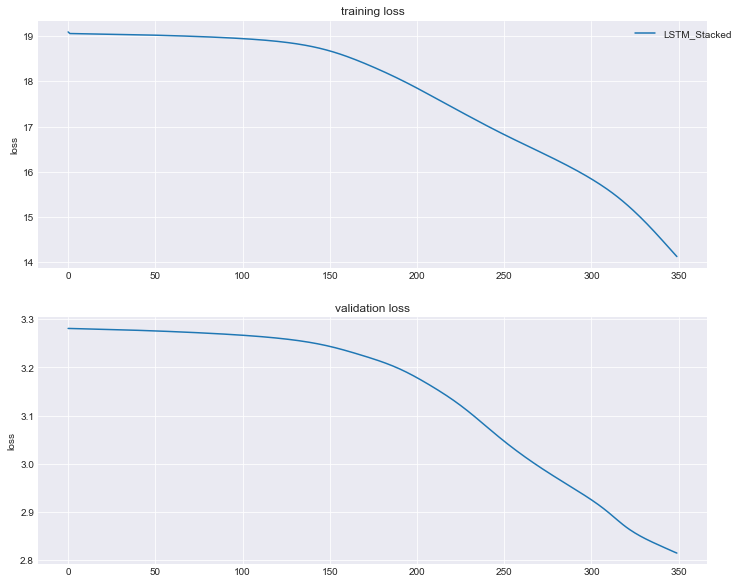

In [30]:
x = [i for i in range(n_epochs)]


fig, ax = plt.subplots(2,1, figsize=(12,10))

for model_ in models:
    name = model_[0]
    training_loss = model_[1]
    valid_loss =model_[2] 

    
    label = name 
    
    ax[0].plot(x,  training_loss, label=label)
    ax[1].plot(x,  valid_loss, label=label)
    #ax[2].plot([i for i in range(n_epochs-1)],  valid_loss[1:] / valid_loss[:-1] * 100, label=label)


#ax[2].set_xlabel('epoch') 

ax[0].set_ylabel('loss') 
ax[1].set_ylabel('loss')

ax[0].set_title("training loss")
ax[1].set_title("validation loss")
#ax[2].set_title("validation loss change in %")

legend  = ax[0].legend(bbox_to_anchor=(1.05, 1))

ax[0].grid()
ax[1].grid()
#ax[2].grid()

# Serializing best model

In [31]:

# =============================================================================
# # Serializing model 
# =============================================================================

wdir= r'C:/Users/hauer/Documents/Repositories/cfds_project'
save_dir = os.path.join(wdir, 'pytorch_models')
model_name = 'rnn.torch'

if(not os.path.isdir(save_dir)):
    os.mkdir(save_dir)
    
save(model.state_dict(), os.path.join(save_dir, model_name))

#model = RNN(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
#model.load_state_dict(load( os.path.join(save_dir, model_name)))

# Using model

In [23]:
country = 'Germany'

df = database_training_sv_standard[country].append(database_validation_sv_standard[country])

n_forecast_validation, _ = database_validation_sv_standard[country].shape

X_eval = df.iloc[:,1:].values
y_eval = df.iloc[:,0].values
X_eval_T = from_numpy(X_eval).float()
N, _ = X_eval_T.shape
X_eval_T = X_eval_T.view([-1, N, dummy_dim])

hidden_1 = zeros(1, N, hidden_dim)
state_1 = zeros(1, N, hidden_dim)

hidden_2 = zeros(1, N, hidden_dim)
state_2 = zeros(1, N, hidden_dim)

model.eval()
with no_grad():
    y_hat = model(X_eval_T, hidden_1, state_1, hidden_2, state_2)
    
y_hat =  y_hat.view(-1).numpy()
y_forecast = y_hat[-n_forecast_validation:]
y_forecast

array([-0.09360281, -0.04636378, -0.18608621,  0.00946208], dtype=float32)

# Comparing with the ground truth.

First check right application of scaling. The unscaled data must equal the scaled data after appling the inverse_transform method from sklearn: 

In [14]:
scaler = database_scaler[country]

database_validation_sv[country]

,y,"Inflation, average consumer prices",ExchangeR,General government net lending/borrowing,GHG,Current account balance,PPP
2009,0.234375,1.869612,0.582607,0.607133,0.690894,1.812187,0.665526
2010,1.860920,1.428403,0.525331,-0.435978,0.634447,1.827969,0.659129
2011,2.091820,1.027137,0.599944,-0.831883,0.667861,1.838487,0.668243
2012,1.984308,0.988643,0.534140,1.587170,0.667618,1.801603,0.661074


In [15]:
pd.DataFrame(scaler.inverse_transform(database_validation_sv_standard[country]))

,0,1,2,3,4,5,6
0,0.234375,1.869612,0.582607,0.607133,0.690894,1.812187,0.665526
1,1.860920,1.428403,0.525331,-0.435978,0.634447,1.827969,0.659129
2,2.091820,1.027137,0.599944,-0.831883,0.667861,1.838487,0.668243
3,1.984308,0.988643,0.534140,1.587170,0.667618,1.801603,0.661074


Transforming the output back to original scale: 

In [16]:
df_output = database_validation_sv_standard[country]

Overwriting the forecast to the dataframe in order to call the inverse_transform method.

In [17]:
df_output.iloc[:,0] = y_forecast
df_output

,0,1,2,3,4,5,6
0,0.850967,0.707503,0.656411,0.298846,3.164935,0.192775,0.120834
1,0.968357,0.414082,-0.333327,-0.384181,-1.162583,0.202497,-0.950455
2,0.799334,0.147225,0.955985,-0.643419,1.399100,0.208976,0.575925
3,0.652370,0.121625,-0.181108,0.940573,1.380516,0.186256,-0.624739


In [18]:
df_output = pd.DataFrame(scaler.inverse_transform(df_output))
df_output

,0,1,2,3,4,5,6
0,3.163407,1.869612,0.582607,0.607133,0.690894,1.812187,0.665526
1,3.360033,1.428403,0.525331,-0.435978,0.634447,1.827969,0.659129
2,3.076922,1.027137,0.599944,-0.831883,0.667861,1.838487,0.668243
3,2.830761,0.988643,0.534140,1.587170,0.667618,1.801603,0.661074


In [19]:
y_forecast = df_output.iloc[:,0].values
y_forecast

array([3.16340733, 3.36003337, 3.07692156, 2.83076093])

In [20]:
database_validation_sv[country].iloc[:,0].values

array([0.23437483, 1.86092044, 2.0918199 , 1.98430846])